# Imports

In [1]:
import sys
sys.path.append('..')
sys.path.append("../UKB-Tools")

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from src.spiro import load_spiro_dataframe
from ukb_tools.data import UKB
from ukb_tools.preprocess.utils import rename_features


sns.set(style='white', context='notebook', rc={'figure.figsize':(7,5)})

DATA_DIR = '../data'
VISIT_ID = '0'

# Load data

In [2]:
df_full = pd.read_csv(os.path.join(DATA_DIR, 'preprocessed.csv'))
df_train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
df_val = pd.read_csv(os.path.join(DATA_DIR, 'val.csv'))
df_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [3]:
ukb = UKB(os.path.join(DATA_DIR, 'raw.csv'))
ukb.load_data(instance=VISIT_ID)
df, feature_names = rename_features(ukb.data, {
    "spirometry": "3066",
    "ranking": "3059",  # 0: best, 1: second best, 2: third best (i.e. worst)
    "acceptability": "3061",
    "fvc": "3062",
    "fev1": "3063",
    "pef": "3064",
})
df = df[feature_names]
df = df[df.index.isin(df_full['eid'])]
df.head()

,spirometry_0,spirometry_1,spirometry_2,ranking_0,ranking_1,ranking_2,acceptability_0,acceptability_1,acceptability_2,fvc_0,fvc_1,fvc_2,fev1_0,fev1_1,fev1_2,pef_0,pef_1,pef_2
eid,,,,,,,,,,,,,,,,,,
1000019,"blow2,758,0,0,0,0,1,4,9,16,26,40,58,82,114,153...","blow3,808,0,0,0,0,1,4,7,12,18,27,38,53,74,102,...","blow1,590,0,0,0,0,1,6,15,28,46,69,99,136,180,2...",0.0,1.0,2.0,0.0,0.0,16.0,3.10,3.07,2.79,2.37,2.36,2.32,406.0,391.0,388.0
1000054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000078,"blow3,818,0,0,0,0,1,5,14,27,44,66,92,124,163,2...","blow1,835,0,0,0,0,1,3,6,9,14,19,25,33,41,51,62...","blow2,815,0,0,0,0,1,5,10,18,29,43,61,84,112,14...",0.0,1.0,2.0,0.0,3.0,2.0,3.58,3.45,3.43,2.88,2.73,2.73,442.0,297.0,366.0
1000081,"blow2,876,0,0,0,0,1,3,7,13,22,35,51,70,98,138,...","blow3,851,0,0,0,0,2,10,24,42,70,111,152,204,26...","blow1,739,0,0,0,0,2,8,16,39,62,94,135,181,247,...",0.0,1.0,2.0,0.0,0.0,0.0,3.03,3.02,2.71,2.10,1.97,1.94,401.0,399.0,358.0


# Preprocess spirometry

### Parse UKB fields

In [4]:
UKB_3066_RECORDS = []
for eid, row in tqdm(df.iterrows(), desc='Parsing spirometry', total=len(df)):
    for i in range(3):
        acceptability = row[f'acceptability_{i}']
        if acceptability == 0 or acceptability == 32:
            fvc = row[f'fvc_{i}']
            fev1 = row[f'fev1_{i}']
            pef = row[f'pef_{i}']
            ranking = row[f'ranking_{i}']
            label = df_full[df_full['eid'] == eid]['Asthma'].iloc[0]
            
            blow = row[f'spirometry_{i}']
            blow = blow.split(',')
            blow_order = int(blow.pop(0)[-1])
            num_points = int(blow.pop(0))
            record = {
                'eid': eid,
                'visit_id': int(VISIT_ID),
                'blow_order': blow_order,
                'num_points': num_points,
                'series': np.asarray([int(val) for val in blow]),
                'fvc': fvc,
                'fev1': fev1,
                'pef': pef,
                'ranking': ranking,
                'label': label
            }
            UKB_3066_RECORDS.append(record)

Parsing spirometry: 100%|██████████| 304978/304978 [05:51<00:00, 868.11it/s] 


### Compute Flow/Volume curve

In [5]:
# Create spiro dataframe from records:
df = load_spiro_dataframe(UKB_3066_RECORDS)
df.head(2)

,eid,visit_id,blow_order,num_points,fvc,fev1,pef,ranking,label,volume_max,...,flow_max,flow_last,time,volume_pad_last,flow_pad_zero,flow_volume_pad_last,blow_fef25,blow_fef50,blow_fef75,blow_fef25_75
0,1000019,0,2,758,3.10,2.37,406.0,0.0,False,3.104,...,7.699999,0.0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.049999997, 0.0...","[0.0, 0.001, 0.004, 0.009, 0.016, 0.026, 0.04,...","[0.0, 0.10000000894069672, 0.30000001192092896...","[0.0, 0.4034634427317558, 0.6192335506506078, ...",5.599999,2.600002,0.600004,1.974074
1,1000019,0,3,808,3.07,2.36,391.0,1.0,False,3.073,...,7.000000,0.0,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.049999997, 0.0...","[0.0, 0.001, 0.004, 0.007, 0.012, 0.018, 0.027...","[0.0, 0.10000000894069672, 0.30000001192092896...","[0.0, 0.30000001192092896, 0.5195528686990447,...",5.599999,2.800000,0.600004,1.966250


### Filter valid samples

In [6]:
import pandas as pd
import numpy as np

def quality_control_spirometry(df: pd.DataFrame, lower_percentile: float = 0.5, upper_percentile: float = 99.5) -> pd.DataFrame:
    """
    Perform quality control on spirometry data by removing blows with extreme FEV1, FVC, or PEF values.
    If multiple valid blows remain for one individual, keep the one with the best ranking (lowest value).
    
    Args:
    df (pd.DataFrame): Input dataframe containing spirometry data with an existing 'ranking' column.
    lower_percentile (float): Lower percentile threshold (default 0.5).
    upper_percentile (float): Upper percentile threshold (default 99.5).
    
    Returns:
    pd.DataFrame: Filtered dataframe with extreme values removed and best blow per individual.
    """
    # Make a copy of the input dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Calculate percentiles for FEV1, FVC, and PEF
    percentiles = {}
    for column in ['fev1', 'fvc', 'pef']:
        lower = np.percentile(df[column], lower_percentile)
        upper = np.percentile(df[column], upper_percentile)
        percentiles[column] = (lower, upper)
    
    # Create a boolean mask for rows to keep
    mask = np.ones(len(df), dtype=bool)
    for column, (lower, upper) in percentiles.items():
        mask &= (df[column] >= lower) & (df[column] <= upper)
    
    # Apply the mask to filter out extreme values
    df_filtered = df[mask].reset_index(drop=True)
    
    # If multiple valid blows remain for one individual, keep the one with the best ranking (lowest value)
    best_blows = df_filtered.loc[df_filtered.groupby('eid')['ranking'].idxmin()]
    
    return best_blows

In [7]:
df = quality_control_spirometry(df)

### Plot curves

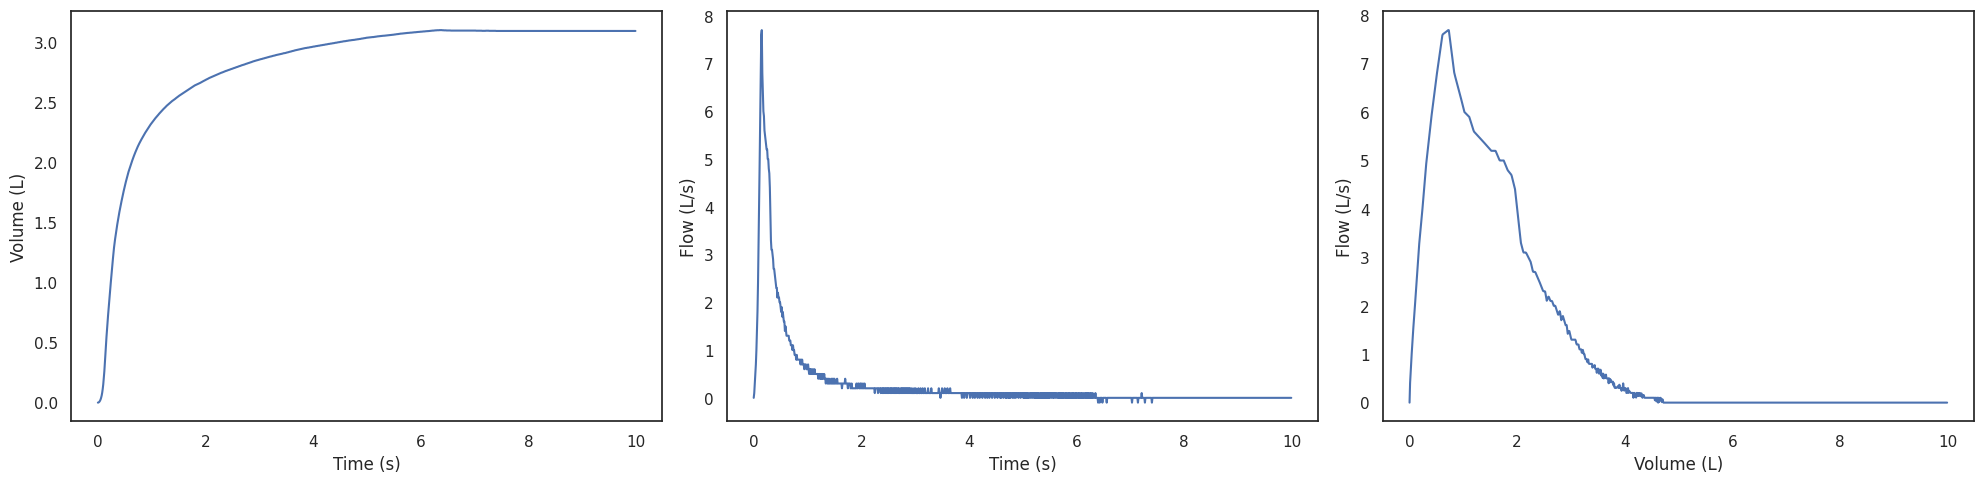

In [8]:
sample = df.iloc[0]
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot volume-time
axs[0].plot(sample.time, sample.volume_pad_last)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Volume (L)')

# Plot flow-time 
axs[1].plot(sample.time, sample.flow_pad_zero)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Flow (L/s)')

# Plot flow-volume 
axs[2].plot(sample.time, sample.flow_volume_pad_last)
axs[2].set_xlabel('Volume (L)')
axs[2].set_ylabel('Flow (L/s)')

plt.tight_layout()
plt.show()

# Save data

In [9]:
df = df.rename(columns={'flow_volume_pad_last': 'flow_volume'})
train_df = df[df['eid'].isin(df_train['eid'])][['eid', 'flow_volume', 'label']]
val_df = df[df['eid'].isin(df_val['eid'])][['eid', 'flow_volume', 'label']]
test_df = df[df['eid'].isin(df_test['eid'])][['eid', 'flow_volume', 'label']]

train_df.to_pickle(os.path.join(DATA_DIR, 'train_spiro.pkl'))
val_df.to_pickle(os.path.join(DATA_DIR, 'val_spiro.pkl'))
test_df.to_pickle(os.path.join(DATA_DIR, 'test_spiro.pkl'))

In [10]:
train_df.head(2)

,eid,flow_volume,label
2,1000078,"[0.0, 0.48814369731012236, 0.8540652394716403,...",False
3,1000081,"[0.0, 0.3793293503423047, 0.605772453337921, 0...",True
